<a href="https://colab.research.google.com/github/SoanKim/SET/blob/main/ver1_Metacog_SET_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stimuli

### Import

In [1]:
import os
import copy
import random
import json
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns
from pandas                import json_normalize
from PIL                   import Image
from itertools             import combinations
from collections           import deque, Counter
from sklearn.decomposition import PCA

In [2]:
from google.colab        import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
file_path= '/content/gdrive/MyDrive/stimuli_combination_2160.csv'
file_read = pd.read_csv(file_path)

### Sanitizing

In [4]:
file_read = file_read.replace(to_replace='\(', value="", regex=True)
file_read = file_read.replace(to_replace='\)', value="", regex=True)
file_read = file_read.replace(to_replace=' ', value="", regex=True)
file_read = file_read.replace(to_replace="'", value="", regex=True)

In [5]:
file_read

,img_card_0,img_card_1,img_card_2,int_card_0,int_card_1,int_card_2,digit_card_00,digit_card_01,digit_card_02,digit_card_03,digit_card_10,digit_card_11,digit_card_12,digit_card_13,digit_card_20,digit_card_21,digit_card_22,digit_card_23,is_set,same_cnt,diff_cnt,no_set
0,red_open_circle_black.png,red_open_circle_grey.png,red_open_circle_white.png,"0,0,0,0","0,0,0,1","0,0,0,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,0,"128,128,128","255,0,0",0.0,0,"255,255,255",1,3,1,0
1,red_open_circle_black.png,red_open_triangle_black.png,red_open_square_black.png,"0,0,0,0","0,0,1,0","0,0,2,0","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","255,0,0",0.0,4,"0,0,0",1,3,1,0
2,red_open_circle_black.png,red_open_triangle_black.png,yellow_open_triangle_white.png,"0,0,0,0","0,0,1,0","1,0,1,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","255,255,0",0.0,3,"255,255,255",0,1,0,1
3,red_open_circle_black.png,red_open_triangle_black.png,yellow_striped_square_white.png,"0,0,0,0","0,0,1,0","1,1,2,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","255,255,0",0.5,4,"255,255,255",0,0,1,1
4,red_open_circle_black.png,red_open_triangle_black.png,green_solid_triangle_white.png,"0,0,0,0","0,0,1,0","2,2,1,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","0,128,0",1.0,3,"255,255,255",0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,green_solid_circle_white.png,green_solid_triangle_black.png,green_solid_square_grey.png,"2,2,0,2","2,2,1,0","2,2,2,1","0,128,0",1.0,0,"255,255,255","0,128,0",1.0,3,"0,0,0","0,128,0",1.0,4,"128,128,128",1,2,2,0
2156,green_solid_circle_white.png,green_solid_triangle_grey.png,green_solid_square_black.png,"2,2,0,2","2,2,1,1","2,2,2,0","0,128,0",1.0,0,"255,255,255","0,128,0",1.0,3,"128,128,128","0,128,0",1.0,4,"0,0,0",1,2,2,0
2157,green_solid_circle_white.png,green_solid_triangle_white.png,green_solid_square_white.png,"2,2,0,2","2,2,1,2","2,2,2,2","0,128,0",1.0,0,"255,255,255","0,128,0",1.0,3,"255,255,255","0,128,0",1.0,4,"255,255,255",1,3,1,0
2158,green_solid_triangle_black.png,green_solid_triangle_grey.png,green_solid_triangle_white.png,"2,2,1,0","2,2,1,1","2,2,1,2","0,128,0",1.0,3,"0,0,0","0,128,0",1.0,3,"128,128,128","0,128,0",1.0,3,"255,255,255",1,3,1,0


### Reshape

In [6]:
digit_card = file_read[['int_card_0', 'int_card_1', 'int_card_2', 'is_set']]

In [7]:
zero = digit_card[str(digit_card.columns[0])].str.split(',', expand=True)
one = digit_card[str(digit_card.columns[1])].str.split(',', expand=True)
two = digit_card[str(digit_card.columns[2])].str.split(',', expand=True)
is_set = digit_card[str(digit_card.columns[3])]

In [8]:
stimuli = pd.concat([zero, one, two, is_set], ignore_index = True ,axis=1)

In [9]:
stimuli[12].value_counts()

1    1080
0    1080
Name: 12, dtype: int64

### Shuffle

In [10]:
shuffled_stimuli_df = stimuli.sample(frac=1)

In [11]:
shuffled_stimuli_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
246,0,0,1,0,0,1,0,2,1,2,0,0,0
850,0,1,1,0,0,1,1,1,2,0,0,1,0
707,0,1,0,0,1,1,2,0,2,1,1,0,1
989,0,1,1,2,1,1,2,0,2,0,2,1,0
624,0,0,2,2,1,0,1,0,2,0,0,1,1


In [12]:
shuffled_stimuli = shuffled_stimuli_df.to_numpy()

In [13]:
shuffled_stimuli.shape

(2160, 13)

In [14]:
shuffled_stimuli.astype('float')

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [0., 2., 0., ..., 2., 2., 0.],
       [2., 0., 2., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 1., 0.]])

### Train and test datasets?

In [15]:
train_ratio = 0.7

In [16]:
train_data = shuffled_stimuli[:int(shuffled_stimuli.shape[0]*train_ratio)]
test_data = shuffled_stimuli[int(shuffled_stimuli.shape[0]*train_ratio):]
train_data.shape

(1512, 13)

# Actor Critic

### Import

In [17]:
import time
import json
import torch
import random
import torch.optim         as optim
import numpy               as np
import torch.nn            as nn
import matplotlib.pyplot   as plt
import torch.nn.functional as F
from collections           import namedtuple, deque
%matplotlib inline

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [19]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-5         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1        # skip training steps
num_agents = 1          # number of agents
EPS_START = 1.0         # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 0.995        # episode to end the noise decay process
EPS_FINAL = 0.01           # final value for epsilon after decay
LEARN_NUM = 1           # number of learning passes

### Path

In [20]:
if not os.path.exists(os.path.join(os.getcwd(), 'logtis')):
  os.mkdir(os.path.join(os.getcwd(), 'logtis'))
logits_path = os.path.join(os.getcwd(), 'logits')

In [21]:
if not os.path.exists(os.path.join(os.getcwd(), 'logtis', 'action_values')):
  os.mkdir(os.path.join(os.getcwd(), 'logtis', 'action_values'))
action_saving_path = os.path.join(os.getcwd(), 'logtis', 'action_values')

### Actor
Batch Norm --> more stable, but slower.

In [25]:
class Actor(nn.Module):
    def __init__(self, state_size=12, action_size=2, seed=0):
        super(Actor, self).__init__()
        fc1_units = 20  
        fc2_units = 20
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc2_units)
        self.fc4 = nn.Linear(fc2_units, action_size) # No PCA
        self.seed = seed

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

### Critic

In [26]:
class Critic(nn.Module):
    def __init__(self, state_size=12, action_size=2, seed=0):
        super(Critic, self).__init__()
        fc1_units = 20  
        fc2_units = 20
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.seed = seed 

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer

In [27]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, done):
        e = self.experience(state, action, reward, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (states, actions, rewards, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent

In [41]:
class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.eps = EPS_START
        self.eps_decay = 1/(EPS_EP_END*LEARN_NUM)  # set decay rate based on epsilon end target
        self.timestep = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def step(self, state, action, reward, done, agent_number):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.timestep += 1
        self.memory.add(state, action, reward, done)
        # Learn, if enough samples are available in memory and at learning interval settings
        if len(self.memory) > BATCH_SIZE and self.timestep % UPDATE_EVERY == 0:
                for _ in range(LEARN_NUM):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, agent_number)
    
    def act(self, states):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().unsqueeze(0).to(device)
        #actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        
        with torch.no_grad():
            for num_agents, state in enumerate(states):
                actions = self.actor_local(state).cpu().data.numpy()
                #actions[num_agents, :] = action
        self.actor_local.train()
        #actions = np.clip(actions, -1, 1)
        return actions

    def learn(self, experiences, gamma, agent_number):
        states, actions, rewards, dones = experiences
    
    # ---------------------------- update critic ---------------------------- #
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        Q_targets = rewards + (gamma * rewards - Q_expected) * (1 - dones)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        
        # Compute actor loss
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step() 
            # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        #θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Main

In [32]:
shuffled_stimuli_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
246,0,0,1,0,0,1,0,2,1,2,0,0,0
850,0,1,1,0,0,1,1,1,2,0,0,1,0
707,0,1,0,0,1,1,2,0,2,1,1,0,1
989,0,1,1,2,1,1,2,0,2,0,2,1,0
624,0,0,2,2,1,0,1,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,1,0,0,0,2,0,1,1,2,2,0,1,0
1354,0,2,1,0,1,0,1,2,2,1,1,1,1
1273,0,2,0,1,1,1,2,1,2,2,2,2,0
2125,2,0,2,2,2,1,1,0,2,2,0,1,1


In [33]:
shuffled_stimuli[1, -1]

0

Episode 100	Average Score: 0.51
Episode 200	Average Score: 0.54
Episode 300	Average Score: 0.51
Episode 400	Average Score: 0.50
Episode 500	Average Score: 0.53
Episode 600	Average Score: 0.47
Episode 700	Average Score: 0.48
Episode 800	Average Score: 0.40
Episode 900	Average Score: 0.49
Episode 1000	Average Score: 0.56
Episode 1100	Average Score: 0.46
Episode 1200	Average Score: 0.53
Episode 1300	Average Score: 0.53
Episode 1400	Average Score: 0.46
Episode 1500	Average Score: 0.56
Episode 1600	Average Score: 0.52
Episode 1700	Average Score: 0.55
Episode 1800	Average Score: 0.44
Episode 1900	Average Score: 0.43
Episode 2000	Average Score: 0.54
Episode 2100	Average Score: 0.51
Episode 2158	Average Score: 0.49

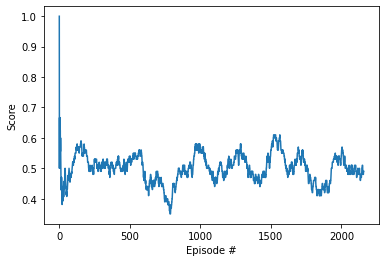

In [42]:
num_agents = 1
n_episodes = shuffled_stimuli.shape[0]
agent = Agent(state_size=12, action_size=2, num_agents=1, random_seed=0)

def Main(n_episodes=n_episodes, max_t=1):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes-1):
        states = shuffled_stimuli[i_episode][:-1].astype('float')
        scores = np.zeros(num_agents)
        label = shuffled_stimuli[i_episode, -1]

        for i in range(max_t):
          actions = torch.from_numpy(agent.act(states))  
          # Based on https://opensourcelibs.com/lib/deeprl-p3-collaboration-competition
          if np.argmax(actions).item() == label:
            rewards = 1
          else:
            rewards = 0

          if i_episode != n_episodes:
            dones = 0
          else:
            dones = 1 
          
          agent.step(states, actions, rewards, dones, 0) 

          scores += rewards
                
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(np.mean(scores_window))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if len(scores_window) == 100 and np.mean(scores_window)>=0.9:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

            break 
            
    return all_scores

scores = Main(n_episodes=n_episodes, max_t=1)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
np.argmax(torch.tensor([[-1.0543, -0.1362]])).item()

1

In [ ]:
n_time_step = 1
labeled_stimuli = shuffled_stimuli#[shuffled_stimuli[:, -1] == label]
n_episodes = labeled_stimuli.shape[0]

def dqn(n_episodes=n_episodes, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    diffs = []
    bets = []
    scores_window = deque(maxlen=100)  # last 100 scores
    diff_window = deque(maxlen=100)
    bet_window = deque(maxlen=100)
    eps = eps_start                    # initialize epsilon
    
    agent = Agent(state_size = 12, action_size=2, seed=0, i_episode=0)

    for i_episode in range(1, n_episodes-1):
      score = 0
      diff = 0
      bet = 0
      state = labeled_stimuli[i_episode][:-1].astype('float')
      
      for t in range(n_time_step):
        action, diff, bet = agent.act(state, eps, i_episode)
        if float(action) == float(labeled_stimuli[i_episode][-1]):
          reward = 1
        else:
          reward = 0

        if i_episode != n_episodes:
          done = 0
        else:
          done = 1 
        # print("done:", done)

        agent.step(state, action, reward, done, diff)
        score += reward
        diff += diff
        bet += bet

        if done:
            break
        # Saving logits for every state
        torch.save(agent.qnetwork_local.state_dict(), 'chkpt_'+str(i_episode)+'.pth')
      scores_window.append(score)  
      diff_window.append(diff)
      bet_window.append(bet)

      scores.append(np.mean(scores_window))  
      diffs.append(np.mean(diff_window))
      bets.append(np.mean(bet_window))

      eps = max(eps_end, eps_decay*eps) # decrease epsilon
      print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Prob Gap: {:.2f}\tBet: {}'.format(i_episode, np.mean(scores_window), np.mean(diff_window), np.bool(bet)), end="")

      if i_episode % 1 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Prob Gap: {:.2f}\tBet: {}'.format(i_episode, np.mean(scores_window), np.mean(diff_window), np.bool(bet)))

      if len(scores_window)>=100 and np.mean(scores_window)>=0.99*n_time_step:
          print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
          break
        
    return scores, diffs, bets

### Training

Episode 1	Average Score: 0.00	Average Prob Gap: 0.26	Bet: False
Episode 2	Average Score: 0.50	Average Prob Gap: 0.26	Bet: False
Episode 3	Average Score: 0.67	Average Prob Gap: 0.25	Bet: False
Episode 4	Average Score: 0.75	Average Prob Gap: 0.25	Bet: False
Episode 5	Average Score: 0.60	Average Prob Gap: 0.26	Bet: False
Episode 6	Average Score: 0.67	Average Prob Gap: 0.27	Bet: False
Episode 7	Average Score: 0.57	Average Prob Gap: 0.27	Bet: False
Episode 8	Average Score: 0.50	Average Prob Gap: 0.26	Bet: False
Episode 9	Average Score: 0.56	Average Prob Gap: 0.26	Bet: False
Episode 10	Average Score: 0.60	Average Prob Gap: 0.27	Bet: False
Episode 11	Average Score: 0.64	Average Prob Gap: 0.26	Bet: False
Episode 12	Average Score: 0.67	Average Prob Gap: 0.27	Bet: False
Episode 13	Average Score: 0.69	Average Prob Gap: 0.27	Bet: False
Episode 14	Average Score: 0.64	Average Prob Gap: 0.27	Bet: False
Episode 15	Average Score: 0.67	Average Prob Gap: 0.26	Bet: False
Episode 16	Average Score: 0.62	Ave

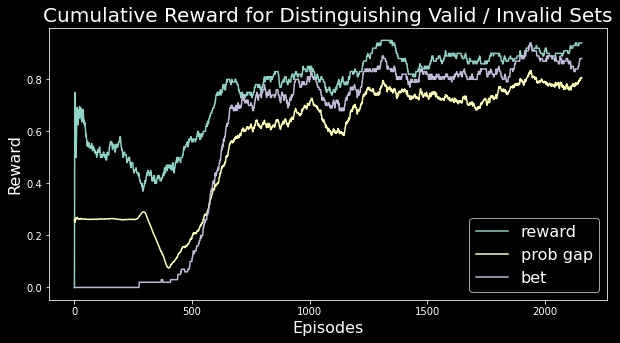

Score specs: 0.76 0.16
Diff specs: 0.57 0.22
Bet specs: 0.59 0.34


In [ ]:
scores, diffs, bets = dqn()

# plot the scores
plt.style.use('dark_background')
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label="reward")
plt.plot(np.arange(len(diffs)), diffs, label="prob gap")
plt.plot(np.arange(len(bets)), bets, label="bet")

plt.legend(loc=4, fontsize=16)
plt.title("Cumulative Reward for Distinguishing Valid / Invalid Sets", fontsize=20)
plt.ylabel('Reward', fontsize = 16)
plt.xlabel('Episodes', fontsize = 16)
plt.show()
print("Score specs: {:.2f} {:.2f}".format(np.mean(scores), np.std(scores)))
print("Diff specs: {:.2f} {:.2f}".format(np.mean(diffs), np.std(diffs)))
print("Bet specs: {:.2f} {:.2f}".format(np.mean(bets), np.std(bets)))

# PCA

### The First Layer

[ 0.  1.  2. ...  9. 10. 11.]


(24000, 3)

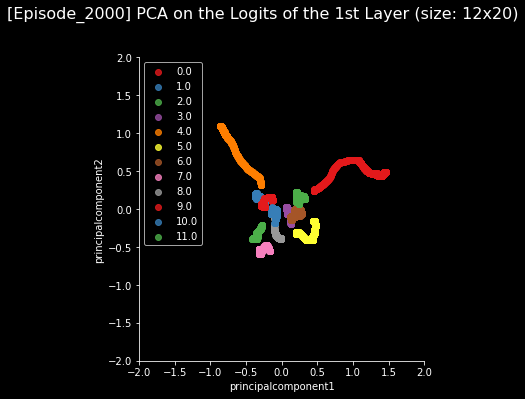

In [ ]:
#https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap
pca = PCA(n_components=2)
max_i_episode = 2000
total_logits = np.zeros((12*(max_i_episode), 20))
total = np.array([])
labels = np.array([])

for i_episode in range(max_i_episode):
    chkpt_file_name = 'chkpt_'+str(i_episode+1)+'.pth'
    chkpt_file_read = torch.load(chkpt_file_name)
    logits = chkpt_file_read['fc1.weight'].numpy().T #(12, 20)
    total_logits[12*(i_episode):12*(i_episode+1), :] = logits
    labels = np.append(labels, [list(range(12))])
print(labels)
principalComponents = pca.fit_transform(total_logits)
principalDf =pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])


principalDf['is_set'] = labels


rp = sns.lmplot(x="principalcomponent1", y="principalcomponent2", data=principalDf, 
           fit_reg=False, legend=False, palette="Set1", hue='is_set')
plt.suptitle("[Episode_"+str(max_i_episode)+'] PCA on the Logits of the 1st Layer (size: 12x20)', fontsize=16, y=1.1)
rp.ax.set_xlim(left=-2, right=2)
rp.ax.set_ylim(bottom=-2, top=2)
plt.legend(fontsize=10)
plt.tight_layout()
principalDf.shape